# Setup
## Import required packages

In [1]:
import struct
import random
import itertools
import datetime
import multiprocessing
from collections import defaultdict
import json
import traceback
import glob

from matplotlib import pyplot as plt
import matplotlib
from matplotlib import ticker
import numpy as np
from scipy import signal as sig
from scipy import fftpack as fftpack
import ipywidgets
from IPython.display import set_matplotlib_formats

from tqdm.notebook import tqdm
import colorednoise

np.set_printoptions(linewidth=240)

In [2]:
#%matplotlib widget
%matplotlib inline
set_matplotlib_formats('png', 'pdf')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6}
matplotlib.rc('font', **font)

## Define mains frequency sampling rate

This is the rate of mains frequency measurements, also called "reporting rate".

In [3]:
sampling_rate = 10 # sp/s

## Library functions
### Gold code generator

In [4]:
# From https://github.com/mubeta06/python/blob/master/signal_processing/sp/gold.py
preferred_pairs = {5:[[2],[1,2,3]], 6:[[5],[1,4,5]], 7:[[4],[4,5,6]],
                        8:[[1,2,3,6,7],[1,2,7]], 9:[[5],[3,5,6]], 
                        10:[[2,5,9],[3,4,6,8,9]], 11:[[9],[3,6,9]]}

def gen_gold(seq1, seq2):
    gold = [seq1, seq2]
    for shift in range(len(seq1)):
        gold.append(seq1 ^ np.roll(seq2, -shift))
    return gold

def gold(n):
    n = int(n)
    if not n in preferred_pairs:
        raise KeyError('preferred pairs for %s bits unknown' % str(n))
    t0, t1 = preferred_pairs[n]
    (seq0, _st0), (seq1, _st1) = sig.max_len_seq(n, taps=t0), sig.max_len_seq(n, taps=t1)
    return gen_gold(seq0, seq1)

### Gold code modulator

In [5]:
def modulate(data, nbits=5, pad=True):
    # 0, 1 -> -1, 1
    mask = np.array(gold(nbits))*2 - 1
    
    sel = mask[data>>1]
    data_lsb_centered = ((data&1)*2 - 1)

    signal = (np.multiply(sel, np.tile(data_lsb_centered, (2**nbits-1, 1)).T).flatten() + 1) // 2
    if pad:
        return np.hstack([ np.zeros(len(mask)), signal, np.zeros(len(mask)) ])
    else:
        return signal

### Gold code correlator

This function, used by the prototype demodulation algorithm below, correlates a signal against all 2^n+1 Gold sequences. Given an input signal of length $k$ it produces an output matrix of dimensions $(2^n+1, k)$ with one column for each shift of the reference Gold sequences w.r.t. the input signal and one row per Gold sequence.

In [6]:
def correlate(sequence, nbits=5, decimation=1, mask_filter=lambda x: x):
    mask = np.tile(np.array(gold(nbits))[:,:,np.newaxis]*2 - 1, (1, 1, decimation)).reshape((2**nbits + 1, (2**nbits-1) * decimation))

    # Our input signal has large DC bias. Remove DC bias to reduce numerical errors during correlation.
    sequence -= np.mean(sequence)
    
    return np.array([np.correlate(sequence, row, mode='full') for row in mask])

### Read recorded mains frequency data from exported capture file

In [7]:
with open('data/fmeas_export_ocxo_2day.bin', 'rb') as f:
    meas_data = np.copy(np.frombuffer(f.read(), dtype='float32'))
    print('mean:', np.mean(meas_data), 'len:', len(meas_data))
    meas_data -= np.mean(meas_data)
    def mains_noise(n):
        last_valid = len(meas_data) - n
        start = np.random.randint(last_valid)
        return meas_data[start:start+n]

mean: 50.00341 len: 1946174


### Test signal generator

This generates deterministically random test data, modulates it using the Gold code modulator, scales it to a given target amplitude and adds noise from recorded data above.

In [8]:
def generate_test_signal(duration, nbits=6, signal_amplitude=2.0e-3, decimation=10, seed=0, data=None):
    test_data = np.random.RandomState(seed=seed).randint(0, 2 * (2**nbits), duration) if data is None else data
    
    signal = np.repeat(modulate(test_data, nbits) * 2.0 - 1, decimation) * signal_amplitude
    noise = mains_noise(len(signal))
    
    return test_data, signal + noise

## Signal exporters for hardware testing
The following two functions generate test data to test the firmware implementation in software simulations.

In [9]:
def do_export_clean():
    test_duration = 200
    test_nbits = 5
    test_signal_amplitude=2.0e-3
    test_decimation=10

    for test_signal_amplitude in [2.0e-3, 20e-3, 200e-3, 2]:
        test_data = np.random.RandomState(seed=0).randint(0, 2 * (2**test_nbits), test_duration)
        #test_data = np.array([0, 1, 2, 3] * 50)
        signal = np.repeat(modulate(test_data, test_nbits, pad=False) * 2.0 - 1, test_decimation) * test_signal_amplitude
        with open(f'dsss_test_signals/dsss_test_noiseless_{test_signal_amplitude*1000:.0f}mHz.bin', 'wb') as f:
            for e in signal:
                f.write(struct.pack('<f', e))

In [10]:
def do_export_noisy():
    test_duration = 32
    test_nbits = 5
    test_signal_amplitude=2.0e-3
    test_decimation=10
    test_signal_amplitude = 200e-3
    noise_level = 10e-3

    #test_data = np.random.RandomState(seed=0).randint(0, 2 * (2**test_nbits), test_duration)
    #test_data = np.array([0, 1, 2, 3] * 50)
    test_data = np.array(range(test_duration))
    signal = np.repeat(modulate(test_data, test_nbits, pad=False) * 2.0 - 1, test_decimation) * test_signal_amplitude
    noise = colorednoise.powerlaw_psd_gaussian(1, len(signal)*10) * noise_level
    noise[-int(1.5*len(signal)):][:len(signal)] += signal

    with open(f'dsss_test_signals/dsss_test_noisy_padded.bin', 'wb') as f:
        for e in noise:
            f.write(struct.pack('<f', e))

# The algorithm

## First we define some components used in our algorithm.

The following function is used to score a new correlation peak against previous peaks. The aim is to assign a high fitness the closer the peak lies to a multiple of one symbol period from the last peak. The first peak is the ideal case, subsequent peaks correspond to dropped symbols.

In [11]:
nonlinear_distance = lambda x: 100**(2*np.abs(0.5-x%1)) / (np.abs(x)+3)**2 * (np.clip(np.abs(x), 0, 0.5) * 2)**5

def plot_distance_func():
    fig, ax = plt.subplots()
    x = np.linspace(-0.2, 5.5, 10000)
    ax.plot(x, nonlinear_distance(x))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


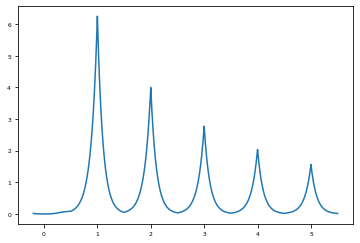

In [12]:
plot_distance_func()

## Ricker wavelet computations for firmware implementation
For our firmware implementation we need a ricker wavelet lookup table. To find out the size of this lookup table, we calculate the truncation error for a given size below.

In [13]:
noprint = lambda *args, **kwargs: None

Text(0.5, 1.0, 'Ricker wavelet, w=69 a=7.3')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


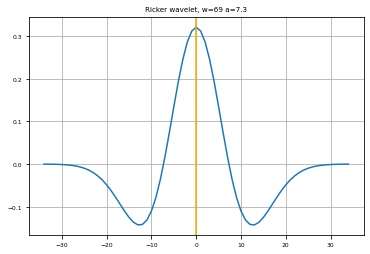

In [14]:
fig, ax = plt.subplots()
w = 69
a = 7.3
ax.plot(range(-w//2+1, w//2+1), sig.ricker(w, a))
ax.grid()
ax.axvline(0, color='orange')
ax.set_title(f'Ricker wavelet, w={w} a={a}')

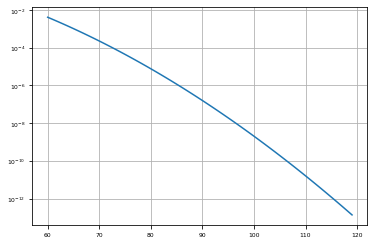

In [15]:
fig, ax = plt.subplots()
r = list(range(60, 120))
ax.plot(r, [sum(sig.ricker(w, a)) for w in r])
ax.set_yscale('log')
ax.grid()

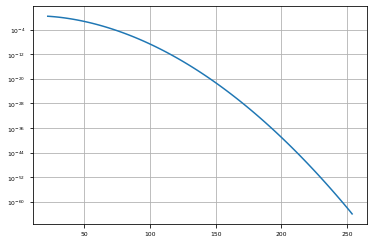

In [16]:
fig, ax = plt.subplots()
sw = 256
w = sig.ricker(sw, a)
r = list(range(1, sw//2 - 10))
d = [-sum(w[:i]) - sum(w[-i:]) for i in r]
ax.plot([sw-2*x for x in r], d)
ax.set_yscale('log')
ax.grid()

## Demodulation algorithm and testing function

The following function contains our prototype demodulation algorithm implementation along with test code applying it to simulated input data. By repeatedly running this function while sweeping parameters we can create plots of our algorithm's performance under various conditions.

In [17]:
def run_ser_test(sample_duration=128, nbits=6, signal_amplitude=2.0e-3, decimation=10, threshold_factor=4.0, power_avg_width=2.5, max_lookahead=6.5, pol_score_factor=1.0, seed=0, ax=None, print=print, ser_maxshift=3, debug_range=None):

    print('>    1 Generating test signal')
    # Generate test data for this simulation run
    test_data, signal = generate_test_signal(sample_duration, nbits, signal_amplitude, decimation, seed)
    
    # === Begin of our prototype demodulation algorithm. ===
    # (1) Correlate the input signal against all 2^n+1 gold sequences using the correlation function defined above.
    cor_an = correlate(signal, nbits=nbits, decimation=decimation)

    # span to compute average power measurements for peak finding over, in samples
    power_avg_width = int(power_avg_width * (2**nbits - 1) * decimation)

    bit_period = (2**nbits) * decimation # duration of one DSSS symbol
    peak_group_threshold = 0.05 * bit_period # Duration over which to group several detected peaks into one, in samples
    hole_patching_threshold = 0.01 * bit_period # Duration over which to ignore temporary dropouts in signal during grouping
    
    print('>    2 CWT')
    # (2) Calculate continuous wavelet transform of correlator output and a ricker wavelet. The width factor of the ricker wavelet at 0.73*decimation was
    # determined empirically. This transform acts like a sharpening filter on our peaks and will increase SNR for the following thresholding step.
    cwt_res = np.array([ sig.cwt(row, sig.ricker, [0.73 * decimation]).flatten() for row in cor_an ])
    if ax:
        ax.grid()
        ax.plot(cwt_res.T)
        
    # (3) Threshold CWT'ed correlator outputs using the factors defined above. Classify any sample as part of a peak that is threshold_factor times
    # larger than the average of the surrounding signal. 
    th = np.array([ np.convolve(np.abs(row), np.ones((power_avg_width,))/power_avg_width, mode='same') for row in cwt_res ])

    # Helper function for thresholding
    def compare_th(elem):
        idx, (th, val) = elem
        #print('compare_th:', th.shape, val.shape)
        return np.any(np.abs(val) > th*threshold_factor)

    print('>    3 Peak grouping')
    # (4) Group samples above threshold value into spans
    peaks = [ list(group) for val, group in itertools.groupby(enumerate(zip(th.T, cwt_res.T)), compare_th) if val ]
    peaks_processed = []
    peak_group = []
    # For each span of samples above threshold, try to coalesce this span with adjacent spans if it is close enough
    for group in peaks:
        pos = np.mean([idx for idx, _val in group])
        #pol = np.mean([max(val.min(), val.max(), key=abs) for _idx, (_th, val) in group])
        pol = max([max(val.min(), val.max(), key=abs) for _idx, (_th, val) in group], key=abs)
        pol_idx = np.argmax(np.bincount([ np.argmax(np.abs(val)) for _idx, (_th, val) in group ]))
        peaks_processed.append((pos, pol, pol_idx))
        #print(f'group', pos, pol, pol_idx)
        #for pol, (_idx, (_th, val)) in zip([max(val.min(), val.max(), key=abs) for _idx, (_th, val) in group], group):
        #    print('    ', pol, val)
        #if ax:
        #    ax.axvline(pos, color='cyan', alpha=0.3)
        msg = f'peak at {pos} = {pol} idx {pol_idx}: '

        if peak_group:
            msg += f'continuing previous group: {peak_group[-1]},'
            group_start, last_pos, last_pol, peak_pos, last_pol_idx = peak_group[-1]

            if abs(pol) > abs(last_pol):
                msg += 'larger, '
                if ax:
                    ax.axvline(pos, color='magenta', alpha=0.5)
                peak_group[-1] = (group_start, pos, pol, pos, pol_idx)
                
            else:
                msg += 'smaller, '
                if ax:
                    ax.axvline(pos, color='blue', alpha=0.5)
                peak_group[-1] = (group_start, pos, last_pol, peak_pos, last_pol_idx)
        else:
            last_pos = None
        
        if not peak_group or pos - last_pos > peak_group_threshold:
            msg += 'terminating, '
            if peak_group:
                msg += f'previous group: {peak_group[-1]},'
                peak_pos = peak_group[-1][3]
                if ax:
                    ax.axvline(peak_pos, color='red', alpha=0.6)
                #ax3.text(peak_pos-20, 2.0, f'{0 if pol < 0 else 1}', horizontalalignment='right', verticalalignment='center', color='black')

            msg += f'new group: {(pos, pos, pol, pos, pol_idx)} '
            peak_group.append((pos, pos, pol, pos, pol_idx))
            if ax:
                ax.axvline(pos, color='cyan', alpha=0.5)
        
        if debug_range:
            low, high = debug_range
            if low < pos < high:
                print(msg)
                print(group)

    print('>    4 Maximum-likelihood decoding')
    # Calculate average magnitude of all found peaks for normalization in next step
    avg_peak = np.mean(np.abs(np.array([last_pol for _1, _2, last_pol, _3, _4 in peak_group])))
    print('avg_peak', avg_peak)

    # (5) Perform Maximum likelihood estimation to group peaks into chains of peaks spaced at one-symbol duration intervals.
    noprint = lambda *args, **kwargs: None
    def mle_decode(peak_groups, print=print):
        """ Maximum likelihood estimation decoding.
        
        This function tries to find sequences of peaks that are spaced at one-symbol intervals. It will yield candidate sequences along with their by fitness.
        A sequence is evaluated better the higher its peaks, the closer they match one-symbol intervals from each other and the longer it is. """
        # For each peak, extract index inside capture (in samples), polarity and the index of the Gold sequence that matched to produce this peak
        peak_groups = [ (pos, pol, idx) for _1, _2, pol, pos, idx in peak_groups ]
        
        # Initially populate candidate array with all peaks in first couple of symbol periods from signal start.
        candidates = [ (abs(pol)/avg_peak, [(pos, pol, idx)]) for pos, pol, idx in peak_groups if pos < bit_period*2.5 ]

        # Iterate while there are candidates remaining
        while candidates:
            chain_candidates = [] # candidates for next iteration
            for chain_score, chain in candidates:
                pos, ampl, _idx = chain[-1]
                score_fun = lambda pos, npos, npol: pol_score_factor*abs(npol)/avg_peak + nonlinear_distance((npos-pos)/bit_period)
                
                # For this candidate, consider all peaks that might extend it to a longer chain up to some maximum timestamp in the future.
                next_candidates = sorted([ (score_fun(pos, npos, npol), npos, npol, nidx) for npos, npol, nidx in peak_groups if pos < npos < pos + bit_period*max_lookahead ], reverse=True)

                print(f'    candidates for {pos}, {ampl}:')
                for score, npos, npol, nidx in next_candidates:
                    print(f'        {score:.4f} {npos:.2f} {npol:.2f} {nidx:.2f}')

                nch, cor_len = cor_an.shape
                if cor_len - pos < 1.5*bit_period or not next_candidates:
                    # If we have hit the end of our signal or if we did not detect any more peaks, calculate this candidate's score and yield it to the caller.
                    score = sum(score_fun(opos, npos, npol) for (opos, _opol, _oidx), (npos, npol, _nidx) in zip(chain[:-1], chain[1:])) / len(chain)
                    yield score, chain

                else:
                    # If we have not yet hit the end of our signal, and we still have peaks left try to extend the current candidate with each of these peaks in turn.
                    # Calculate the score of the resulting extended chains and if they are not too bad, append them to the candidates for the next iteration
                    print('extending')
                    for score, npos, npol, nidx in next_candidates[:3]:
                        if score > 0.5:
                            new_chain_score = chain_score * 0.9 + score * 0.1
                            chain_candidates.append((new_chain_score, chain + [(npos, npol, nidx)]))
            
            # For next iteration select top-n highest scoring candidates just computed
            print('chain candidates:')
            for score, chain in sorted(chain_candidates, reverse=True):
                print('    ', [(score, [(f'{pos:.2f}', f'{pol:.2f}') for pos, pol, _idx in chain])])
            candidates = [ (chain_score, chain) for chain_score, chain in sorted(chain_candidates, reverse=True)[:10] ]

    # Group peaks into chains and select the chain with the highest score
    res = sorted(mle_decode(peak_group, print=noprint), reverse=True)
    #for i, (score, chain) in enumerate(res):
    #    print(f'Chain {i}@{score:.4f}: {chain}')
    (_score, chain), *_ = res

    def viz(chain, peaks):
        last_pos = None
        for pos, pol, nidx in chain:
            if last_pos:
                delta = int(round((pos - last_pos) / bit_period))
                if delta > 1:
                    print(f'skipped {delta-1} symbols at {pos}/{last_pos}')
                    
                    # Hole patching routine
                    for i in range(1, delta):
                        est_pos = last_pos + (pos - last_pos) / delta * i

                        icandidates = [ (ipos, ipol, iidx) for ipos, ipol, iidx in peaks if abs(est_pos - ipos) < hole_patching_threshold ]
                        if not icandidates:
                            yield None
                            continue

                        ipos, ipol, iidx = max(icandidates, key = lambda e: abs(e[1]))

                        decoded = iidx*2 + (0 if ipol < 0 else 1)
                        print(f'interpolating, last_pos={last_pos}, delta={delta}, pos={pos}, est={est_pos} dec={decoded}')
                        yield decoded
            
            decoded = nidx*2 + (0 if pol < 0 else 1)
            yield decoded
            if ax:
                ax.axvline(pos, color='blue', alpha=0.5)
                ax.text(pos-20, 0.0, f'{decoded}', horizontalalignment='right', verticalalignment='center', color='black')

            last_pos = pos

    print('>    5 Matching')
    decoded = list(viz(chain, peaks_processed))
    print('decoding [ref|dec]:')
    match_result = []
    for shift in range(-ser_maxshift, ser_maxshift):
        msg = f'=== shift = {shift} ===\n'
        failures = -shift if shift < 0 else 0 # we're skipping the first $shift symbols
        a = test_data if shift > 0 else test_data[-shift:]
        b = decoded if shift < 0 else decoded[shift:]
        for i, (ref, found) in enumerate(itertools.zip_longest(a, b)):
            if ref is None: # end of signal
                break
            msg += f'{ref if ref is not None else -1:>3d}|{found if found is not None else -1:>3d} {"✔" if ref==found else "✘" if found else " "}   '
            if ref != found:
                failures += 1
            if i%8 == 7:
                msg += '\n'
        match_result.append((failures, msg))
    failures, msg = min(match_result, key=lambda e: e[0])
    print(msg)
    ser = failures/len(test_data)
    print(f'Symbol error rate e={ser}: {failures}/{len(test_data)}')
    br = sampling_rate / decimation / (2**nbits) * nbits * (1 - ser) * 3600
    print(f'maximum bitrate r={br} b/h')
    return ser, br

0it [00:00, ?it/s]

scheduled 50 tasks. waiting...
done


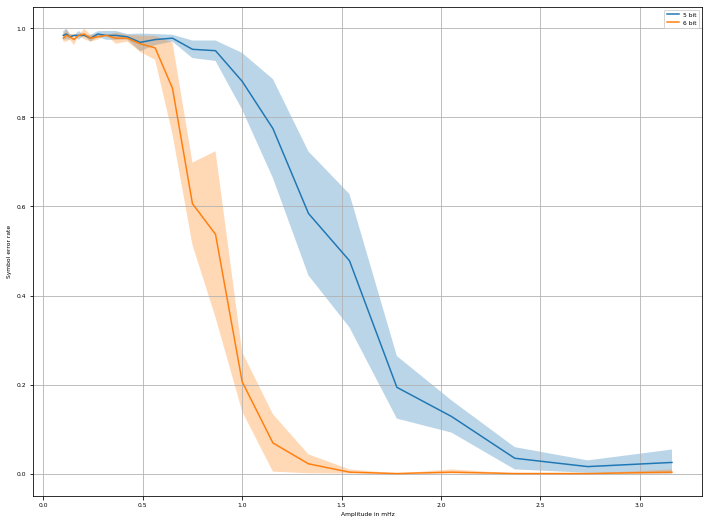

In [20]:
default_params = dict(
        decimation=10,
        power_avg_width=2.5,
        max_lookahead=6.5)

fig, ax = plt.subplots(figsize=(12, 9))

def calculate_ser(v, seed, nbits, thf, reps, duration):
    st = np.random.RandomState(seed)
    params = dict(default_params)
    params['signal_amplitude'] = v
    params['nbits'] = nbits
    params['threshold_factor'] = thf
    sers, brs = [], []
    for i in range(reps):
        seed = st.randint(0xffffffff)
        try:
            ser, br = run_ser_test(**params, sample_duration=duration, print=noprint, seed=seed)
            sers.append(ser)
            brs.append(br)
        except Exception as e:
            traceback.print_exc()
            print('got', e, 'seed', seed, 'params', params)
            #sers.append(1.0)
            #brs.append(0.0)
        #print(f'nbits={nbits} ampl={v:>.5f} seed={seed:08x} > ser={ser:.5f}')
    sers, brs = np.array(sers), np.array(brs)
    ser, std = np.mean(sers), np.std(sers)
    #print(f'signal_amplitude={v:<.5f}: ser={ser:<.5f} ±{std:<.5f}, br={np.mean(brs):<.5f}')
    return ser, std

results = {}
st = np.random.RandomState(0)
with tqdm(total = 0) as tq:
    with multiprocessing.Pool(multiprocessing.cpu_count()//2) as pool:
        for nbits, thf, reps, points, duration in [(5, 4.0, 5, 25, 64), (6, 4.0, 5, 25, 64)]: #[(5, 4.0, 50, 25, 128), (6, 4.0, 25, 25, 64), (7, 5.0, 10, 10, 64), (8, 6.0, 5, 10, 32)]:
            #print(f'nbits={nbits}')
            vs = 0.1e-3 * 10 ** np.linspace(0, 1.5, points)
            results[nbits] = [ pool.apply_async(calculate_ser, (v, st.randint(0xffffffff), nbits, thf, reps, duration), callback=lambda _res: tq.update(1)) for v in vs ]
            tq.total += len(vs)
            tq.refresh()
        
        pool.close()
        pool.join()

        print(f'scheduled {tq.total} tasks. waiting...')
        results = { nbits: [ res.get() for res in series ] for nbits, series in results.items() }
        print('done')

with open(f'dsss_experiments_res-{datetime.datetime.now():%Y-%m-%d %H:%M:%S}.json', 'w') as f:
    json.dump(results, f)
    
for nbits, res in results.items():
    data = np.array(res)
    sers, stds = data[:,0], data[:,1]

    l, = ax.plot(vs*1e3, np.clip(sers, 0, 1), label=f'{nbits} bit')
    ax.fill_between(vs*1e3, np.clip(sers + stds, 0, 1), np.clip(sers - stds, 0, 1), facecolor=l.get_color(), alpha=0.3)
ax.grid()
ax.set_xlabel('Amplitude in mHz')
ax.set_ylabel('Symbol error rate')
ax.legend()

0it [00:00, ?it/s]

Starting 0.0001/0
Starting 0.000316227766016838/0
>    1 Generating test signalStarting 0.0014677992676220691/0
Starting 0.00046415888336127784/0
Starting 0.001/0
Starting 0.0021544346900318834/0
Starting 0.0006812920690579612/0
>    1 Generating test signalStarting 0.0031622776601683794/0

>    1 Generating test signal>    1 Generating test signal>    1 Generating test signal>    1 Generating test signal>    1 Generating test signal>    1 Generating test signal






Starting 0.00014677992676220695/0
>    1 Generating test signal
Starting 0.0002154434690031884/0
>    1 Generating test signal


KeyboardInterrupt: 

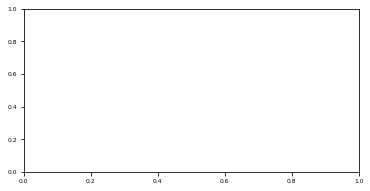

In [18]:
default_params = dict(
        decimation=10,
        power_avg_width=2.5,
        max_lookahead=6.5)

fig, ax = plt.subplots(figsize=(6, 3))

def calculate_ser(v, seed, nbits, thf, reps, duration):
    st = np.random.RandomState(seed)
    params = dict(default_params)
    params['signal_amplitude'] = v
    params['nbits'] = nbits
    params['threshold_factor'] = thf
    sers, brs = [], []
    for i in range(reps):
        seed = st.randint(0xffffffff)
        try:
            print(f'Starting {v}/{i}\n', end='', flush=True)
            ser, br = run_ser_test(**params, sample_duration=duration, print=print, seed=seed)
            sers.append(ser)
            brs.append(br)
            print(f'Finishing {v}/{i}\n', end='', flush=True)
        except Exception as e:
            traceback.print_exc()
            print('got', e, 'seed', seed, 'params', params)
            #sers.append(1.0)
            #brs.append(0.0)
        #print(f'nbits={nbits} ampl={v:>.5f} seed={seed:08x} > ser={ser:.5f}')
    sers, brs = np.array(sers), np.array(brs)
    ser, std = np.mean(sers), np.std(sers)
    #print(f'signal_amplitude={v:<.5f}: ser={ser:<.5f} ±{std:<.5f}, br={np.mean(brs):<.5f}')
    return ser, std

results = {}
st = np.random.RandomState(0)
with tqdm(total = 0) as tq:
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        for nbits, thf, reps, points, duration in [(10, 4.0, 5, 10, 10)]:
            #print(f'nbits={nbits}')
            vs = 0.1e-3 * 10 ** np.linspace(0, 1.5, points)
            results[nbits] = [ pool.apply_async(calculate_ser, (v, st.randint(0xffffffff), nbits, thf, reps, duration), callback=lambda _res: tq.update(1)) for v in vs ]
            tq.total += len(vs)
            tq.refresh()
        
        pool.close()
        pool.join()

        print(f'scheduled {tq.total} tasks. waiting...')
        results = { nbits: [ res.get() for res in series ] for nbits, series in results.items() }
        print('done')

with open(f'dsss_experiments_res-{datetime.datetime.now():%Y-%m-%d %H:%M:%S}.json', 'w') as f:
    json.dump(results, f)
    
for nbits, res in results.items():
    data = np.array(res)
    sers, stds = data[:,0], data[:,1]

    l, = ax.plot(vs*1e3, np.clip(sers, 0, 1), label=f'{nbits} bit')
    ax.fill_between(vs*1e3, np.clip(sers + stds, 0, 1), np.clip(sers - stds, 0, 1), facecolor=l.get_color(), alpha=0.3)
ax.grid()
ax.set_xlabel('Amplitude in mHz')
ax.set_ylabel('Symbol error rate')
ax.legend()

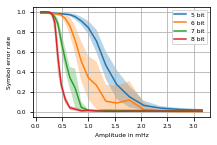

In [22]:
fig, ax = plt.subplots(figsize=(3, 2))

#    sers, brs = np.array(sers), np.array(brs)
#    ser, std = np.mean(sers), np.std(sers)
#    results = { nbits: [ res.get() for res in series ] for nbits, series in results.items() }

with open(f'data/dsss_experiments_res-2020-02-19-19-30-05.json', 'r') as f:
    results = json.load(f)

for nbits, series in results.items():
    series = [ [ mean for mean, _std, _msg in reps if mean is not None ] for reps in series ]
    sers = np.array([ np.mean(values) for values in series ])
    stds = np.array([ np.std(values)  for values in series ])

    # FIXME HACK HACK HACK
    vs = 0.1 * 10 ** np.linspace(0, 1.5, 25)
    
    l, = ax.plot(vs, np.clip(sers, 0, 1), label=f'{nbits} bit')
    ax.fill_between(vs, np.clip(sers + stds, 0, 1), np.clip(sers - stds, 0, 1), facecolor=l.get_color(), alpha=0.3)
ax.grid()
ax.set_xlabel('Amplitude in mHz')
ax.set_ylabel('Symbol error rate')
ax.legend()
fig.tight_layout()
fig.savefig('fig_out/dsss_gold_nbits_overview.pdf')

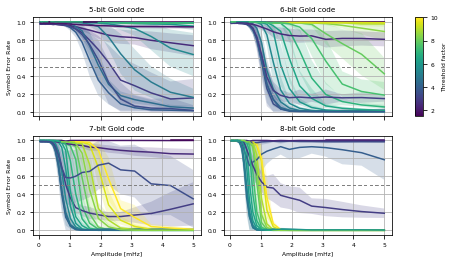

In [23]:
default_files = [
    #    'data/dsss_experiments_res-2020-02-20-12-18-35.json',
    #    'data/dsss_experiments_res-2020-02-20-12-26-07.json',
    #    'data/dsss_experiments_res-2020-02-20-12-29-02.json'
        'data/dsss_experiments_res-par107-run115-0-2020-04-07-11-41-37.json',
        'data/dsss_experiments_res-par107-run115-1-2020-04-07-13-23-42.json',
        'data/dsss_experiments_res-par107-run115-2-2020-04-07-08-57-38.json',
        'data/dsss_experiments_res-par107-run115-3-2020-04-07-15-48-04.json',
    ]

def load_results(*files):
    results = []
    for fn in files:
        with open(fn, 'r') as f:
            results += json.load(f)
    return results

def thf_dependence_plot(results, plot_nbits=6,
                        ax=None, cbar_ax=None, intercept_ax=None,
                        xlabel=True, x2label=False, ylabel=True, y2label=True, y2ticks=True, ic_ylim=[-0.5, 5],
                        legend_loc=4, split_legend=False, calc_best_ampl=False):

    thfs = [thf for (_nbits, thf, _reps, _points, _duration, _decimation), series in results]
    cmap = matplotlib.cm.viridis
    cm_func = lambda x: cmap((x - min(thfs)) / (max(thfs) - min(thfs)))

    thf_sers = {}
    for (nbits, thf, reps, points, duration, decimation), series in results:
        if nbits != plot_nbits:
            continue
        data = [ [ mean for mean, _std, _msg in reps if mean is not None ] for _amp, reps in series ]
        amps = [ amp*1000 for amp, _reps in series ]
        sers = np.array([ np.mean(values) for values in data ])
        stds = np.array([ np.std(values)  for values in data ])
        thf_sers[thf] = list(zip(amps, sers, stds))

        if ax:
            l, = ax.plot(amps, np.clip(sers, 0, 1), label=f'thf={thf}', color=cm_func(thf))
            ax.fill_between(amps, np.clip(sers + stds, 0, 1), np.clip(sers - stds, 0, 1), facecolor=l.get_color(), alpha=0.2)
            ax.axhline(0.5, color='gray', ls=(0, (3, 4)), lw=0.8)
    if ax:
        ax.grid()
        ax.set_title(f'{plot_nbits}-bit Gold code')
        if xlabel:
            ax.set_xlabel('Amplitude [mHz]')
        else:
            ax.xaxis.set_ticklabels([])
        if ylabel:
            ax.set_ylabel('Symbol Error Rate')

    def plot_base_amp(ax):
        base_sers = {}
        for thf, sers in thf_sers.items():
            base = np.mean([ser for amp, ser, std in sorted(sers)[-2:]])
            base_std = np.sqrt(np.mean([std**2 for amp, ser, std in sorted(sers)[-2:]]))
            base_sers[thf] = (base, base_std)

        x = sorted(base_sers.keys())
        y = np.array([ base_sers[thf][0] for thf in x ])
        std = np.array([ base_sers[thf][1] for thf in x ])
        l = ax.plot(x, y, label='SER at large amplitudes')
        ax.fill_between(x, y-std, y+std, color=l[0].get_color(), alpha=0.3)
        return l

    def plot_intercepts(ax, SER_TH = 0.5):
        intercepts = {}
        for thf, sers in thf_sers.items():
            last_ser, last_amp, last_std = 0, 0, 0
            for amp, ser, std in sorted(sers):
                if last_ser > SER_TH and ser < SER_TH:
                    icp = last_amp + (SER_TH - last_ser) / (ser - last_ser) * (amp - last_amp)
                    ic_std = abs(last_amp - amp) / 2# np.sqrt(np.mean(last_std**2 + std**2))
                    intercepts[thf] = (icp, ic_std)
                    break
                last_amp, last_ser = amp, ser
            else:
                intercepts[thf] = None, None

        ser_valid = [thf for thf, (ser, _std) in intercepts.items() if ser is not None]
        #ax.axvline(min(ser_valid), color='red')
        #ax.axvline(max(ser_valid), color='red')

        x = sorted(intercepts.keys())
        data = np.array([ intercepts[thf] for thf in x ])
        y = data[:,0]
        std = data[:,1]

        if ax:
            ax.set_xlim([min(x), max(x)])
            l = ax.plot(x, y, label='Amplitude at SER=0.5', color='orange')
        else:
            l = None

        x, y, std = zip(*[ (le_x, le_y, le_std) for le_x, le_y, le_std in zip(x, y, std) if le_y is not None ])
        y, std = np.array(y), np.array(std)
        if ax:
            ax.fill_between(x, y-std, y+std, color=l[0].get_color(), alpha=0.3)

            trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
            ax.fill_between([-1, min(ser_valid)], 0, 1, facecolor='red', alpha=0.2, transform=trans, zorder=1)
            ax.fill_between([max(ser_valid), max(ser_valid)*10], 0, 1, facecolor='red', alpha=0.2, transform=trans)
            ax.set_ylim([min(y)*0.9, max(y)*1.1])
            ax.grid()
        
        best_ampl = (np.inf, np.nan)
        for yval, stdval in zip(y, std):
            if yval < best_ampl[0]:
                best_ampl = [yval, stdval]
        
        return l, best_ampl

    if intercept_ax:
        if isinstance(intercept_ax, tuple):
            intercept_ax, intercept_ax_twin = intercept_ax
        else:
            intercept_ax_twin = intercept_ax.twinx()
            
    if intercept_ax or calc_best_ampl:
        l1, best_ampl = plot_intercepts(intercept_ax)
    else:
        best_ampl = None
        
    if intercept_ax:
        l2 = plot_base_amp(intercept_ax_twin)
        
        intercept_ax.set_title(f'{plot_nbits}-bit Gold code')
        if xlabel:
            intercept_ax.set_xlabel('Threshold factor')
        if x2label:
            intercept_ax_twin.set_xlabel('Threshold factor')
        if ylabel:
            intercept_ax.set_ylabel('Amplitude [mHz]')
        intercept_ax.set_ylim(ic_ylim)
        intercept_ax_twin.set_ylim([-0.1, 1])
        if y2label:
            intercept_ax_twin.set_ylabel('Symbol Error Rate')
        if not y2ticks:
            intercept_ax_twin.set_yticklabels([])
        if legend_loc is not None:
            if split_legend:
                intercept_ax.legend(l1, [l1[0].get_label()], loc=legend_loc)
                intercept_ax_twin.legend(l2, [l2[0].get_label()], loc=legend_loc)
            else:
                intercept_ax.legend(l1 + l2, [l.get_label() for l in l1+l2], loc=legend_loc)

    if cbar_ax:
        norm = matplotlib.colors.Normalize(vmin=min(thfs), vmax=max(thfs))
        cb1 = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical', label="Threshold factor")
        
    return best_ampl

import warnings
warnings.filterwarnings('ignore')


def plot_gold_sensitivity(results, nbitses=[5,6,7,8]):
    nbitses = np.array(nbitses)
    ampls = np.array([ thf_dependence_plot(plot_nbits=dep_n, results=results, calc_best_ampl=True) for dep_n in nbitses ])
    fig, ax = plt.subplots(figsize=(3, 2))
    l = ax.plot(nbitses, ampls[:,0])
    ax.fill_between(nbitses, ampls[:,0]-ampls[:,1], ampls[:,0]+ampls[:,1], color=l[0].get_color(), alpha=0.3)
    ax.grid()
    ax.set_xlabel('Gold code bits')
    ax.set_ylabel('Amplitude at SER=0.5 [mHz]')
    ax.set_ylim([0, 2])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    fig.tight_layout()
    return fig

def plot_amplitude_ber(results, grid=(2, 3), nbitses=[5,6,7,8], figsize=(12, 9), xlim=None, xlog=False):
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(*grid, figure=fig, width_ratios=[1, 1, 0.05])
    
    cbar_ax = fig.add_subplot(gs[0, 2])
    
    axs = np.empty([2, 2], dtype=object)
    for i, nbits in enumerate(nbitses):
        row, col = i//2, i%2
        
        ax = axs[row, col] = fig.add_subplot(gs[row, col])
        if xlog:
            ax.set_xscale('log')
        if xlim is not None:
            ax.set_xlim(xlim)
        if row == 1:
            ax.get_shared_x_axes().join(axs[0, col])
        if col == 1:
            ax.get_shared_y_axes().join(axs[row, 0])
            
        xlabel = row==1 if len(nbitses) > 2 else True
        thf_dependence_plot(plot_nbits=nbits, ax=ax, cbar_ax=cbar_ax if i==0 else None, xlabel=xlabel, ylabel=col==0, results=results)
        
    return fig

def plot_thf_graph(results, nbitses=[5,6,7,8], ic_ylim=[-0.5, 5], figsize=(12, 9)):
    fig, axs = plt.subplots(2, 2, figsize=figsize, sharex='col', sharey='row', gridspec_kw={'wspace': 0.1})
    for nbits, ax, ax_below in zip(nbitses, axs.flatten(), [*axs.flatten()[2:], None, None]):
        if len(nbitses) <= 2:
            ax = ax, ax_below
            ax_below.grid()
            y2label = nbits in [5, 7]
            legend_loc = 9
            y2ticks = True
        else:
            y2ticks = y2label = nbits in [6, 8]
            legend_loc = 1
        thf_dependence_plot(plot_nbits=nbits, intercept_ax=ax,
                            xlabel=nbits in [7, 8], ylabel=nbits in [5, 7], y2label=y2label, ic_ylim=ic_ylim,
                            y2ticks=y2ticks, x2label=len(nbitses) <= 2,
                            legend_loc=legend_loc if nbits == nbitses[-1] else None,
                            split_legend =  len(nbitses) <= 2,
                            results=results)
    return fig

#plot_gold_sensitivity(load_results(*default_files))\
#.savefig('fig_out/dsss_gold_nbits_sensitivity.pdf');

#plot_amplitude_ber(load_results(*default_files), figsize=(7, 4))\
#.savefig('fig_out/dsss_thf_amplitude_5678.pdf');

#plot_thf_graph(load_results(*default_files), figsize=(7, 4))\
#.savefig('fig_out/dsss_thf_sensitivity_5678.pdf')

# Note: due to a mistake these "par114" files actually contain "par115" data.
#plot_thf_graph(load_results('data/dsss_experiments_res-par114-run120-0-2020-04-08-20-03-56.json'),
#               nbitses=[5,6], ic_ylim=[-4.99, 30],
#              figsize=(7, 4))\
#.savefig('fig_out/dsss_thf_sensitivity_56.pdf');

#plot_amplitude_ber(load_results('data/dsss_experiments_res-par114-run120-0-2020-04-08-20-03-56.json'), nbitses=[5,6],
#                  xlog=True, xlim=[5e-2, 5e1],
#                  figsize=(7, 4))\
#.savefig('fig_out/dsss_thf_amplitude_56.pdf');

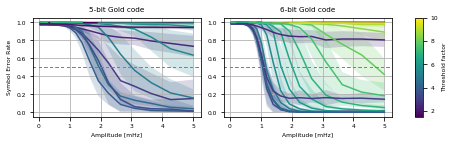

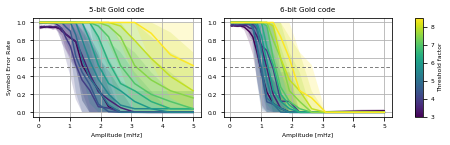

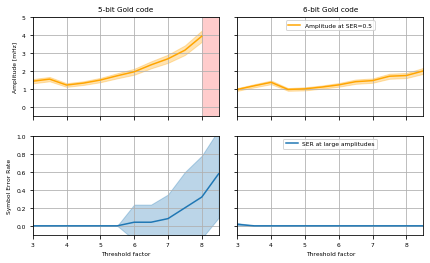

In [26]:
def load_results_fw_sim(*files, background=None, filter_decimation=None):
    results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: [])))
    
    for fn in files:
        with open(fn, 'r') as f:
            for (nbits, thf, decimation, symbols, seed, amp, background), result in json.load(f):
                if filter_decimation is None or decimation == filter_decimation:
                    results[background][(nbits, thf, symbols, decimation)][amp].append(result)
                
    if len(results) > 1:
        if background is None:
            raise ValueError('Results series contains series for multiple noise backgrounds. Please select one.')
        
        results = results[background]
    else:
        results = list(results.values())[0]
    
    out = []
    for (nbits, thf, duration, decimation), series in results.items():
        out_series = []
        for amplitude, amplitude_series in sorted(series.items(), key=lambda x: x[0]):
            reps = len(amplitude_series)
            out_amplitude_series = [(ser if ser is not None else 1.0, None, None) for ser in amplitude_series]
            out_series.append((amplitude, out_amplitude_series))
        out.append(((nbits, thf, reps, len(series), duration, decimation), out_series))
    return out

plot_amplitude_ber(load_results(*default_files), nbitses=[5, 6], figsize=(7, 4))\
.savefig('fig_out/dsss_thf_amplitude_56_jupyter_impl.pdf');

fw_sim_res = load_results_fw_sim(*glob.glob('data/fw_sim_ser_2/*.json'), filter_decimation=10)
plot_amplitude_ber(results=fw_sim_res, nbitses=[5, 6], figsize=(7, 4))\
.savefig('fig_out/dsss_thf_amplitude_56_fw_impl.pdf');
plot_thf_graph(results=fw_sim_res, nbitses=[5, 6], figsize=(7, 4))\
.savefig('fig_out/dsss_thf_sensitivity_56_fw_impl.pdf');

In [70]:
#sorted([x[0] for x in fw_sim_res])
#sorted({amp for _params, series in fw_sim_res for amp, reps in series}),\
#sorted({amp for _params, series in load_results(*default_files) for amp, reps in series})

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


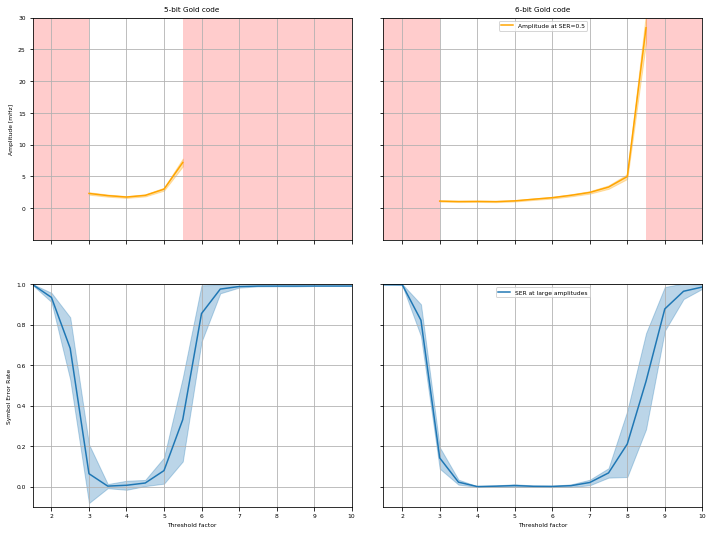

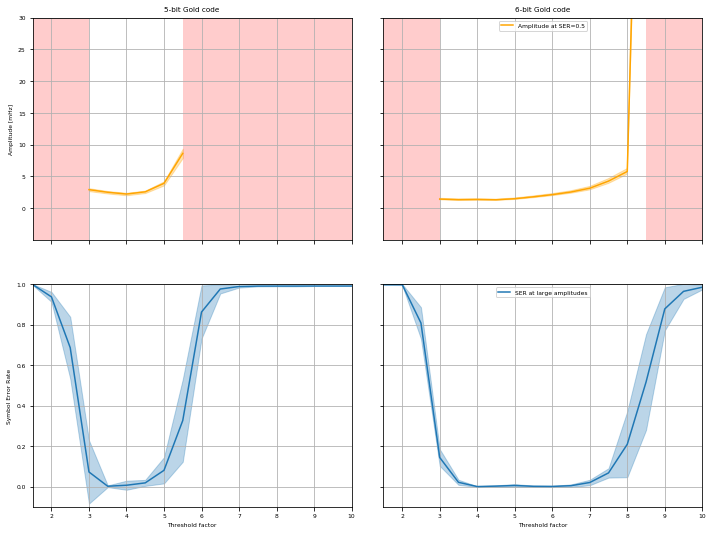

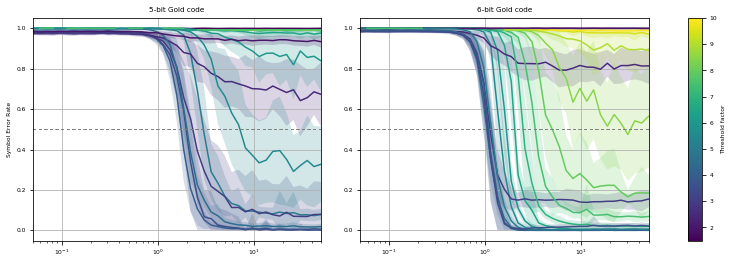

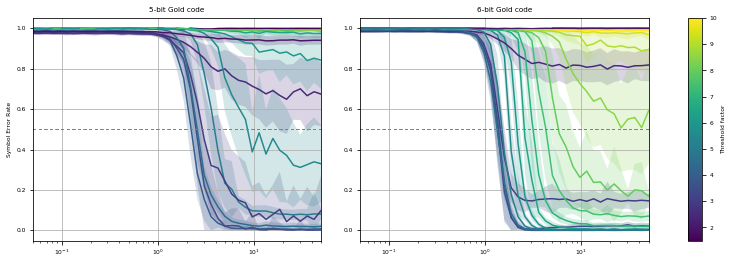

In [43]:
extra_amp_files = ['data/dsss_experiments_res-par114-run120-0-2020-04-08-20-03-56.json']
synth_files = [
    'data/dsss_experiments_res-par115-synth-run122-0-2020-04-11-20-07-33.json',
    'data/dsss_experiments_res-par115-synth-run122-1-2020-04-11-20-39-19.json'
]

# Note: due to a mistake these "par114" files actually contain "par115" data.
plot_thf_graph(extra_amp_files, nbitses=[5,6], ic_ylim=[-4.99, 30],);
plot_thf_graph(synth_files, nbitses=[5,6], ic_ylim=[-4.99, 30]);

plot_amplitude_ber(extra_amp_files, nbitses=[5,6], xlog=True, xlim=[5e-2, 5e1]);
plot_amplitude_ber(synth_files, nbitses=[5,6], xlog=True, xlim=[5e-2, 5e1]);

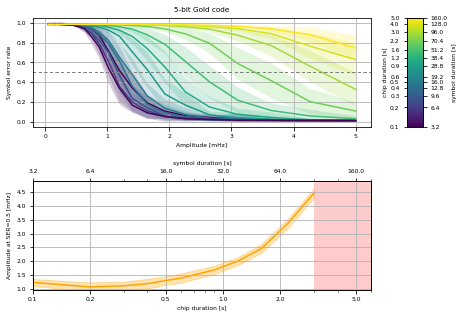

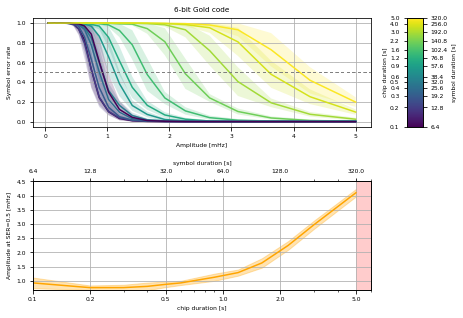

In [59]:
chip_duration_default_files = [
#    'data/dsss_experiments_res-2020-02-20-14-10-13.json',
#    'data/dsss_experiments_res-2020-02-20-13-21-57.json',
#    'data/dsss_experiments_res-2020-02-20-13-23-47.json',
#    'data/dsss_experiments_res-2020-02-20-19-51-21.json',
#    'data/dsss_experiments_res-2020-02-20-20-43-32.json',
#    'data/dsss_experiments_res-2020-02-20-21-36-42.json',
#    'data/dsss_experiments_res-par107-run115-0-2020-04-07-11-41-37.json',
#    'data/dsss_experiments_res-par107-run115-1-2020-04-07-13-23-42.json',
#    'data/dsss_experiments_res-par107-run115-2-2020-04-07-08-57-38.json',
#    'data/dsss_experiments_res-par107-run115-3-2020-04-07-15-48-04.json',
    'data/dsss_experiments_res-par114-run119-0-2020-04-08-20-13-44.json'
]

def plot_chip_duration_sensitivity(only_nbits=5, files=chip_duration_default_files, only_thf=None, figsize=(12, 9)):
    fig, ((ax, cbar_ax), (intercept_ax, empty)) = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'width_ratios': [1, 0.05], 'hspace': 0.5})
    empty.axis('off')
    #fig.tight_layout()

    results = []

    for fn in files:
        with open(fn, 'r') as f:
            results += json.load(f)

    decimations = [decimation for (_nbits, thf, _reps, _points, _duration, decimation), series in results if decimation > 0]
    cmap = matplotlib.cm.viridis
    cm_func = lambda x: cmap(np.log10(x - min(decimations)) / (np.log10(max(decimations)) - np.log10(min(decimations))))

    decimation_sers = {}
    for (nbits, thf, reps, points, duration, decimation), series in results:
        if only_thf is not None and thf != only_thf:
            continue
        if nbits != only_nbits:
            continue
        if not decimation > 0:
            continue
        data = [ [ mean for mean, _std, _msg in reps if mean is not None ] for _amp, reps in series ]
        amps = [ amp for amp, _reps in series ]
        sers = np.array([ np.mean(values) for values in data ])
        stds = np.array([ np.std(values)  for values in data ])
        decimation_sers[decimation] = list(zip(amps, sers, stds))

        amps = [ amp*1000 for amp in amps ]
        l, = ax.plot(amps, np.clip(sers, 0, 1), label=f'decimation={decimation}', color=cm_func(decimation))
        ax.fill_between(amps, np.clip(sers + stds, 0, 1), np.clip(sers - stds, 0, 1), facecolor=l.get_color(), alpha=0.2)
        ax.axhline(0.5, color='gray', ls=(0, (3, 4)), lw=0.8)
    ax.grid()
    ax.set_xlabel('Amplitude [mHz]')
    ax.set_ylabel('Symbol error rate')
    ax.set_title(f'{only_nbits}-bit Gold code')

    norm = matplotlib.colors.Normalize(vmin=np.log10(min(decimations)), vmax=np.log10(max(decimations)))
    tick_decs = sorted(set(float(dec) for dec in decimations))
    yticks = [np.log10(d) for d in tick_decs]
    cb1 = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical', ticks=yticks)
    cb1t = cbar_ax.twinx()
    cb1t.set_ylim(cbar_ax.get_ylim())
    cb1t.set_yticks(yticks)

    cbar_ax.set_yticklabels([f'{d/sampling_rate:.1f}' for d in tick_decs])
    cbar_ax.set_ylabel("chip duration [s]", labelpad=-40)

    cb1t.set_yticklabels([f'{d/sampling_rate * 2**only_nbits:.1f}' for d in tick_decs])
    cb1t.set_ylabel("symbol duration [s]")


    def plot_intercepts(ax, SER_TH = 0.5):
        intercepts = {}
        for dec, sers in decimation_sers.items():
            last_ser, last_amp, last_std = 0, 0, 0
            for amp, ser, std in sorted(sers):
                if last_ser > SER_TH and ser < SER_TH:
                    icp = last_amp + (SER_TH - last_ser) / (ser - last_ser) * (amp - last_amp)
                    ic_std = (abs(last_amp - amp) / 2) + np.sqrt(np.mean(last_std**2 + std**2))
                    intercepts[dec] = (icp, ic_std)
                    break
                last_amp, last_ser = amp, ser
            else:
                intercepts[dec] = None, None

        ser_valid = [dec for dec, (ser, _std) in intercepts.items() if ser is not None]
        #ax.axvline(min(ser_valid), color='red')
        #ax.axvline(max(ser_valid), color='red')

        x = sorted(intercepts.keys())
        data = np.array([ intercepts[dec] for dec in x ])
        y = data[:,0]
        std = data[:,1]
        ax.set_xlim([min(x), max(x)])
        y = [ v*1000 if v is not None else v for v in y ]
        l = ax.plot(x, y, label='Amplitude at SER=0.5 [mHz]', color='orange')
        #ax.legend(loc=3)
        ax.set_ylabel('Amplitude at SER=0.5 [mHz]')
        ax.grid()

        x, y, std = zip(*[ (le_x, le_y, le_std) for le_x, le_y, le_std in zip(x, y, std) if le_y is not None ])
        y, std = np.array(y), np.array(std)
        ax.fill_between(x, y-std, y+std, color=l[0].get_color(), alpha=0.3)

        trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between([-1, min(ser_valid)], 0, 1, facecolor='red', alpha=0.2, transform=trans, zorder=1)
        ax.fill_between([max(ser_valid), max(ser_valid)*10], 0, 1, facecolor='red', alpha=0.2, transform=trans)
        ax.set_ylim([min(y)*0.9, max(y)*1.1])
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
        xticks = [1, 2, 5, 10, 20, 50]
        ax.set_xticks(xticks)
        ax.set_xticklabels([ f'{x/sampling_rate:.1f}' for x in xticks ])
        ax.set_xlim([1, 60])
        ax.set_xlabel('chip duration [s]')

        axt = ax.twiny()
        axt.set_xlim(ax.get_xlim())
        axt.set_xscale('log')
        axt.set_xticks(xticks)
        axt.set_xticklabels([ f'{x/sampling_rate * 2**only_nbits:.1f}' for x in xticks ])
        axt.set_xlabel('symbol duration [s]')

        return l

    l1 = plot_intercepts(intercept_ax)
    return fig

plot_chip_duration_sensitivity(5, figsize=(7, 5))\
.savefig('fig_out/chip_duration_sensitivity_5.pdf');
plot_chip_duration_sensitivity(6, figsize=(7, 5))\
.savefig('fig_out/chip_duration_sensitivity_6.pdf');

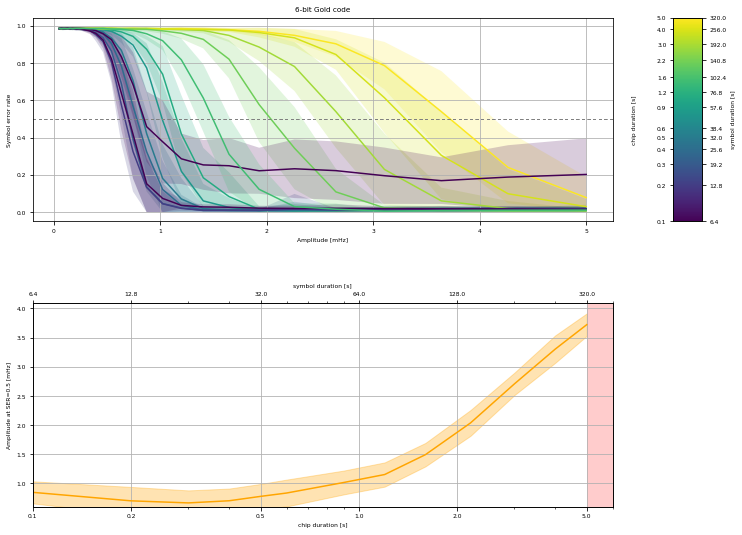

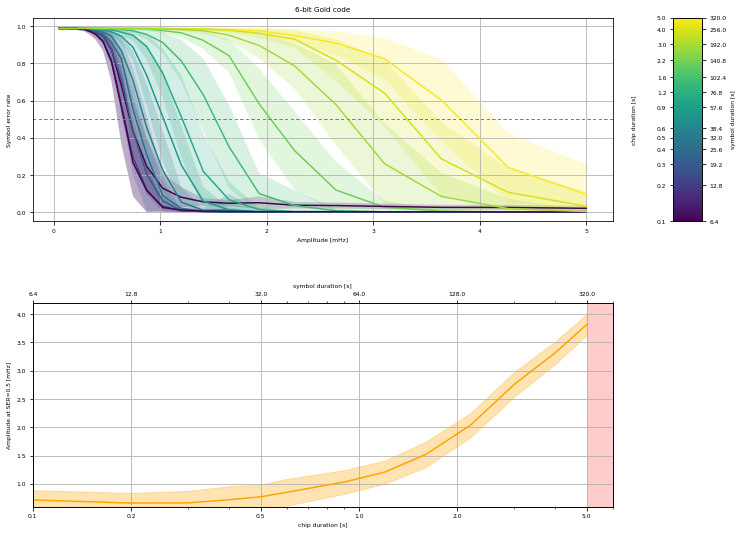

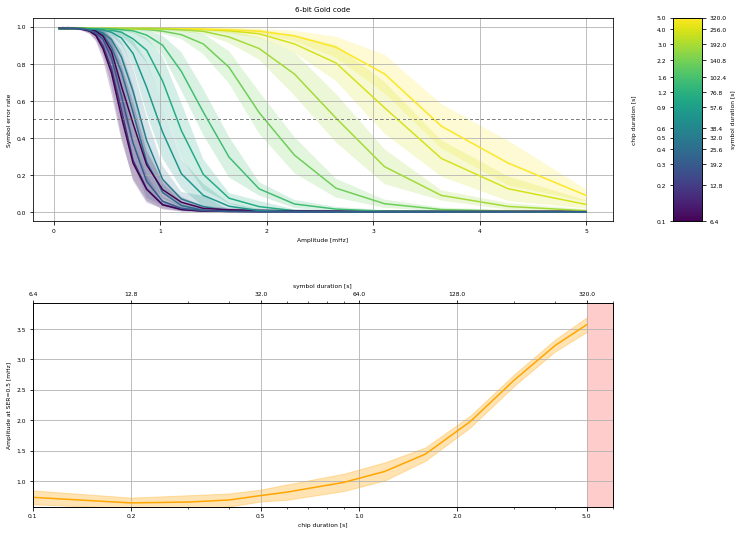

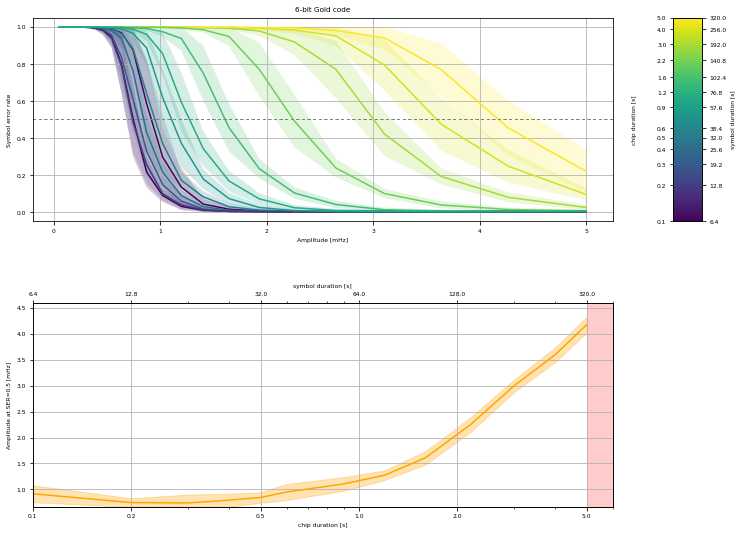

In [45]:
new_files = [
    'data/dsss_experiments_res-par111-run119-0-2020-04-09-04-02-53.json',
    'data/dsss_experiments_res-par111-run119-1-2020-04-08-16-11-20.json',
    'data/dsss_experiments_res-par111-run119-2-2020-04-08-18-07-22.json',
    'data/dsss_experiments_res-par111-run119-3-2020-04-08-13-56-03.json',
            ]
plot_chip_duration_sensitivity(6, only_thf=3.5, files=new_files);
plot_chip_duration_sensitivity(6, only_thf=4.0, files=new_files);
plot_chip_duration_sensitivity(6, only_thf=4.5, files=new_files);
plot_chip_duration_sensitivity(6, only_thf=5.0, files=new_files);
#plot_chip_duration_sensitivity(6, files=new_files);

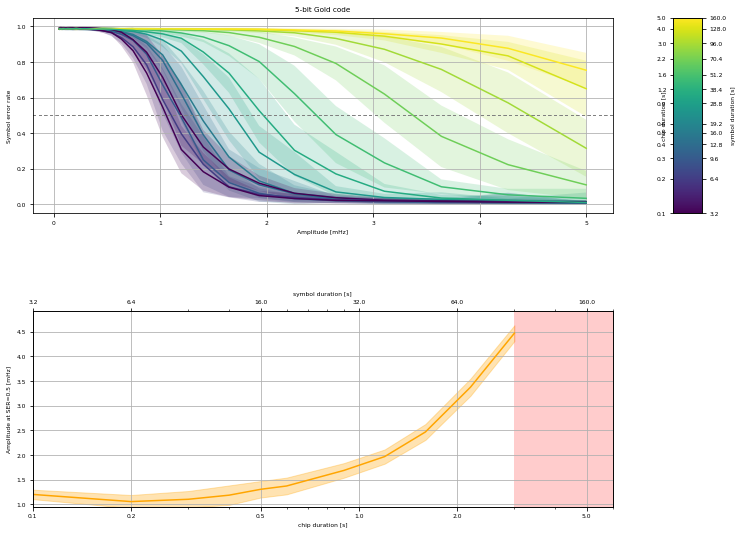

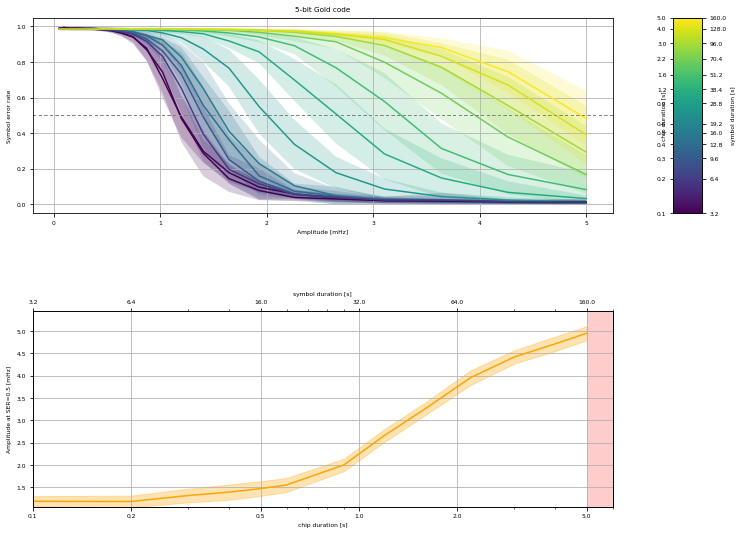

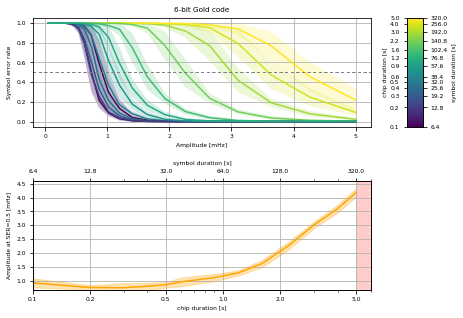

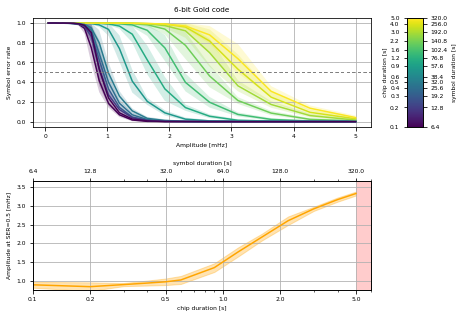

In [60]:
synth_files = [
    'data/dsss_experiments_res-par114-synth-run121-0-2020-04-11-17-50-31.json',
    'data/dsss_experiments_res-par114-synth-run121-1-2020-04-12-03-46-19.json',
    'data/dsss_experiments_res-par114-synth-run121-2-2020-04-11-18-44-15.json',
    'data/dsss_experiments_res-par114-synth-run121-3-2020-04-11-15-25-53.json',
            ]
plot_chip_duration_sensitivity(5, only_thf=4.0, files=new_files);
plot_chip_duration_sensitivity(5, only_thf=4.0, files=synth_files);
plot_chip_duration_sensitivity(6, only_thf=5.0, files=new_files, figsize=(7, 5))\
.savefig('fig_out/chip_duration_sensitivity_cmp_meas_6.pdf');
plot_chip_duration_sensitivity(6, only_thf=5.0, files=synth_files, figsize=(7, 5))\
.savefig('fig_out/chip_duration_sensitivity_cmp_synth_6.pdf');